In [1]:
cd ..

/home/alberto/PycharmProjects/edc_mo_pdac_val


/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Multi-omics stratification on PDAC patients

In [2]:
import os
import pandas as pd
import numpy as np
import dill
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import isolate_rng
import torch
from captum.attr import LayerConductance, NeuronConductance, IntegratedGradients, GradientShap, NoiseTunnel
import types
from scipy.stats import kruskal, mannwhitneyu, kstest
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection


from src import settings
from src.utils import MultiViewDataset, transform_full_dataset
from src.optimization import Optimization
from src.explainability import (
    plot_comparison_attributions_weights, plot_attribution_distribution, plot_feature_importance, layerconductance, neuronconductance,
    FeatureAblationV2, compute_gradients, compute_mv_score, plot_attribution_algorithm_comparison, DeepV2, compute_most_important_features_based_attribution)

In [3]:
data_folder = "data"
processed_data_folder = "processed"
processed_data_path = os.path.join(data_folder, processed_data_folder)
pl.seed_everything(settings.RANDOM_STATE)

Global seed set to 42


42

## Load dataset

In [4]:
files = os.listdir(processed_data_path)
files.remove("clinical_data.csv")
files = list(filter(lambda x: os.path.isfile(os.path.join(processed_data_path, x)), files))
file = -1

In [5]:
Xs = [pd.read_csv(os.path.join(processed_data_path, filename), index_col=0) for filename in files]
samples = Xs[0].index
views = pd.concat([pd.Series(X.columns.str.split("_").str[0]) for X in Xs]).unique().tolist()
views

['pathology', 'CNV', 'freebayes', 'rna']

In [6]:
transformed_Xs = [StandardScaler().set_output(transform="pandas").fit_transform(X) for X in Xs]
for transformed_X in transformed_Xs:
    print("transformed_X.shape", transformed_X.shape)
    display(transformed_X.head())

transformed_X.shape (57, 820)


,pathology_NF40_25%,pathology_NF39_0.01,pathology_NF62_75%,pathology_NF58_0.01,pathology_NF46_0.1,pathology_NF16_0.95,pathology_NF59_min,pathology_NF22_std,pathology_NF37_75%,pathology_NF20_0.05,...,pathology_NF4_50%,pathology_NF63_max,pathology_NF49_50%,pathology_NF32_0.95,pathology_NF15_0.1,pathology_NF26_0.1,pathology_NF6_25%,pathology_NF28_0.1,pathology_NF5_50%,pathology_NF3_mean
GI-19-025,0.367328,-0.810757,-0.552298,2.159154,-0.392823,0.441931,-0.184171,-0.591346,-0.440044,-0.408607,...,1.540788,-0.598281,-0.465733,-0.329815,-0.777184,0.610302,-0.166576,-0.734012,-1.617581,-0.460401
GI-17-537,-0.303663,0.272336,0.152459,-0.593308,-1.758790,-0.249435,-0.114272,0.677331,0.038939,-1.280577,...,-1.460851,-0.231866,0.404248,-0.278571,-0.021564,-1.411418,1.978989,-1.679340,1.402887,1.393700
GI-19-002,-0.877454,0.585332,-0.474427,0.721843,-0.572134,-0.559015,0.113210,-1.013564,0.055880,-0.443388,...,1.088268,-0.963344,0.897686,-0.610395,0.327494,-0.387143,0.028476,-0.221882,-1.096296,-0.339713
GI-16-575,-0.830592,0.464602,-0.342237,-0.390973,-1.088246,-0.776971,-0.538961,-0.395434,0.036546,-0.502933,...,0.821561,0.103607,0.700194,-0.552137,0.305605,-0.182341,-0.055118,-0.793452,-0.801705,-0.197068
GI-14-974,1.035411,-0.506171,5.938190,1.738033,-1.251690,1.770552,5.379658,-1.887434,-2.924526,-0.176278,...,-0.234705,2.262995,-1.841755,-0.550168,-1.428000,1.347103,-1.371714,-1.185991,0.283246,-1.093661


transformed_X.shape (57, 648)


,CNV_HLA-DPB1,CNV_GPC3,CNV_SOX2,CNV_XRCC3,CNV_PAK1,CNV_ACVR1B,CNV_DDR2,CNV_FANCL,CNV_CDKN1B,CNV_DYNC2H1,...,CNV_NBN,CNV_HLA-DQB2,CNV_BRCA2,CNV_RAD51C,CNV_NOTCH2,CNV_DNM2,CNV_TNFRSF9,CNV_FGF9,CNV_ECT2L,CNV_CDKN1A
GI-19-025,-0.006658,0.086567,-0.128606,-0.011112,-0.239676,0.317410,-0.458080,0.390400,-0.108575,-0.100758,...,-0.432470,-0.161173,-0.087496,0.128325,-0.068611,0.179921,0.170748,0.051677,-0.029167,-0.154817
GI-17-537,-0.006658,0.086567,-0.128606,-0.011112,-0.239676,0.317410,1.129206,0.390400,-0.108575,-0.100758,...,-0.432470,-0.161173,-0.087496,0.128325,-0.068611,0.179921,0.170748,0.051677,-0.029167,-0.154817
GI-19-002,-0.006658,0.086567,-0.128606,-0.011112,-0.239676,0.317410,0.804100,-4.321369,-0.108575,-0.100758,...,-0.432470,-0.161173,-0.087496,0.128325,2.215595,0.179921,-2.401717,0.051677,-0.029167,-0.154817
GI-16-575,-1.334892,0.086567,-0.128606,-0.169451,1.452287,-2.096757,-0.458080,-0.204771,-1.011974,1.229244,...,-0.871654,-2.155716,0.189575,-1.666175,-0.068611,1.948692,0.170748,0.434218,-2.228949,-2.155784
GI-14-974,-5.601158,0.086567,0.795413,0.079368,-0.239676,0.317410,-0.483578,0.390400,-0.108575,0.283954,...,-0.306039,-0.161173,0.660597,-0.963979,-0.114757,0.783684,0.133601,1.084538,-0.221775,-0.330016


transformed_X.shape (57, 611)


,freebayes_SNV_HES4,freebayes_SNV_PPP1R3E,freebayes_SNV_UBA52,freebayes_SNV_FGF20,freebayes_SNV_RIT1,freebayes_SNV_IL6R,freebayes_SNV_SOX2,freebayes_SNV_SYNE1,freebayes_SNV_DOT1L,freebayes_SNV_RAD51D,...,freebayes_SNV_MAP3K1,freebayes_SNV_MIR650-MIR5571,freebayes_SNV_MAGEB1-NR0B1,freebayes_SNV_TAP2.2,freebayes_SNV_SDHD,freebayes_SNV_PMS2,freebayes_SNV_PTPRT,freebayes_SNV_HEY2,freebayes_SNV_SOX9,freebayes_SNV_RICTOR
GI-19-025,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,...,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,-0.190693
GI-17-537,0.0,-0.133631,-0.133631,7.483315,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,...,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,5.244044
GI-19-002,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,...,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,-0.190693
GI-16-575,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,...,0.0,-0.133631,-0.133631,-0.133631,0.0,-0.190693,-0.133631,-0.180579,-0.190693,-0.190693
GI-14-974,0.0,-0.133631,-0.133631,-0.133631,-0.133631,-0.133631,-0.235702,-0.350325,-0.133631,-0.190693,...,0.0,-0.133631,-0.133631,-0.133631,0.0,5.244044,-0.133631,-0.180579,-0.190693,-0.190693


transformed_X.shape (57, 2000)


,rna_expr_IL6ST,rna_expr_LPP,rna_expr_REG1A,rna_expr_WASF2,rna_expr_UBXN7,rna_expr_NFAT5,rna_expr_MT-ND4,rna_expr_NOTCH2,rna_expr_ARID1A,rna_expr_PLEC,...,rna_expr_NISCH,rna_expr_MFN2,rna_expr_RNF103,rna_expr_KCNK1,rna_expr_VASH1,rna_expr_TBC1D4,rna_expr_EPS15L1,rna_expr_MANBA,rna_expr_ZNF561,rna_expr_CHD8
GI-19-025,-0.154479,1.720873,-0.663992,0.211719,-0.536917,-0.291813,-0.101337,0.797264,-0.287089,0.420470,...,2.049733,0.474814,0.043321,0.471066,1.272184,0.488833,0.637678,-1.155892,0.736838,-0.601676
GI-17-537,-0.429055,-0.470332,-0.668303,-0.296201,-1.449938,-1.026930,-0.616297,-2.086651,-0.938892,1.664829,...,0.006706,0.034058,-0.788790,0.856090,-1.495812,-1.646213,-1.959113,0.465773,-1.680937,-0.149380
GI-19-002,0.552056,-0.358276,-0.433958,0.704828,0.091123,-0.220616,-0.206978,-1.143044,0.284007,-0.543119,...,0.725072,-1.426800,2.518113,2.680890,-0.038420,1.299193,0.560943,-0.087747,0.902409,-0.214801
GI-16-575,-0.250413,-0.690903,-0.522742,1.097555,-0.459313,0.234821,0.071028,0.768554,0.507990,0.081801,...,0.714849,0.209502,2.496975,1.802813,0.787575,2.618538,0.563724,0.076825,0.845196,-0.558754
GI-14-974,0.094192,2.121533,1.191894,0.030458,-0.967503,-0.603266,-0.053970,-0.989007,0.989795,-0.741700,...,0.082546,1.831900,0.328788,-0.865642,-0.148522,0.094332,2.463851,-2.155652,0.964566,0.365523


In [7]:
date = "2024051615"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)
optimization_results = pd.read_csv(os.path.join(settings.optimization_path, f"optimization_results_{date}.csv"))
best_trial = optimization_results.iloc[0]
print("optimization_results.shape", optimization_results.shape)
optimization_results.head()

optimization_results.shape (1154, 57)


,number,value,datetime_start,datetime_complete,duration,params_divisor_units,params_lambda_coeff,params_latent_space,params_n_clusters,params_n_epochs,...,user_attrs_val_dist_loss,user_attrs_val_dist_loss_list,user_attrs_val_loss,user_attrs_val_loss_list,user_attrs_val_loss_view_list,user_attrs_val_silhscore,user_attrs_val_silhscore_list,user_attrs_val_total_loss,user_attrs_val_total_loss_list,state
0,629,0.227848,2024-05-20 22:47:13.430750,2024-05-20 22:51:26.203982,0 days 00:04:12.773232,4,0.014443,32,3.0,20.0,...,52.466867,"[14.824589729309082, 593.7324829101562, 31.054...",0.590693,"[0.54910808801651, 0.7255101799964905, 0.70907...","[0.632174301147461, 0.5853453183174133, 0.1425...",0.227848,"[0.19231087, 0.18069632, 0.1267254, 0, 0.41005...",1.333027,"[0.7371271848678589, 9.264452934265137, 1.1443...",COMPLETE
1,616,0.227848,2024-05-20 21:52:08.275070,2024-05-20 21:56:19.767614,0 days 00:04:11.492544,4,0.014440,32,3.0,20.0,...,52.466867,"[14.824589729309082, 593.7324829101562, 31.054...",0.590693,"[0.54910808801651, 0.7255101799964905, 0.70907...","[0.632174301147461, 0.5853453183174133, 0.1425...",0.227848,"[0.19231087, 0.18069632, 0.1267254, 0, 0.41005...",1.332860,"[0.7370799779891968, 9.262563705444336, 1.1442...",COMPLETE
2,640,0.227848,2024-05-20 23:33:52.690210,2024-05-20 23:38:01.799515,0 days 00:04:09.109305,4,0.017118,32,3.0,20.0,...,52.466867,"[14.824589729309082, 593.7324829101562, 31.054...",0.590693,"[0.54910808801651, 0.7255101799964905, 0.70907...","[0.632174301147461, 0.5853453183174133, 0.1425...",0.227848,"[0.19231087, 0.18069632, 0.1267254, 0, 0.41005...",1.473379,"[0.77678382396698, 10.852721214294434, 1.22742...",COMPLETE
3,639,0.227848,2024-05-20 23:29:38.786191,2024-05-20 23:33:45.902595,0 days 00:04:07.116404,4,0.016096,32,3.0,20.0,...,52.466867,"[14.824589729309082, 593.7324829101562, 31.054...",0.590693,"[0.54910808801651, 0.7255101799964905, 0.70907...","[0.632174301147461, 0.5853453183174133, 0.1425...",0.227848,"[0.19231087, 0.18069632, 0.1267254, 0, 0.41005...",1.419764,"[0.7616347670555115, 10.245994567871094, 1.195...",COMPLETE
4,638,0.227848,2024-05-20 23:25:30.261649,2024-05-20 23:29:34.647612,0 days 00:04:04.385963,4,0.016254,32,3.0,20.0,...,52.466867,"[14.824589729309082, 593.7324829101562, 31.054...",0.590693,"[0.54910808801651, 0.7255101799964905, 0.70907...","[0.632174301147461, 0.5853453183174133, 0.1425...",0.227848,"[0.19231087, 0.18069632, 0.1267254, 0, 0.41005...",1.428039,"[0.7639726996421814, 10.339630126953125, 1.200...",COMPLETE


In [8]:
model_path = os.path.join("outputs", "models", "model.pt")
model = torch.load(model_path)
model = model.eval()

In [9]:
batch_size = int(best_trial["user_attrs_batch_size"])
full_data = MultiViewDataset(Xs=transformed_Xs)
full_dataloader = DataLoader(dataset=full_data, batch_size=batch_size, shuffle=False)

In [10]:
clinical_data = pd.read_csv(settings.clinical_data_path, index_col= 0)
clusters = clinical_data["clusters"]
print("clinical_data.shape", clinical_data.shape)
clinical_data.head()

clinical_data.shape (57, 336)


,clinical_Age_at_Diagnosis,clinical_Height,clinical_Weight,clinical_Chemotherapy_Binary,clinical_BMI,clinical_TNM_Mixed_Substage,clinical_Sex_ord,clinical_Site_-_Primary_ICD-O-3_ord,clinical_Histology_Behavior_ICD-O-3_ord,clinical_TNM_Mixed_Stage_ord,...,clinical_secondary_diagnosis_onehot__m8580,clinical_secondary_diagnosis_onehot__n183.1,clinical_secondary_diagnosis_onehot__nan.9,clinical_secondary_diagnosis_onehot__z85828,clinical_secondary_diagnosis_onehot__z87442.1,label_deceased,label_days_to_death,clusters,preds_hc,preds_kmeans
GI-19-025,92,70,168,0,24.102857,1,0,0,85003,0,...,0,0,0,0,0,0,2190,0,0,0
GI-17-537,78,64,119,1,20.424072,3,1,3,85003,1,...,0,0,1,0,0,0,2190,1,1,2
GI-19-002,82,71,258,1,35.979766,3,0,4,85003,1,...,0,0,1,0,0,0,2190,0,0,0
GI-16-575,66,67,147,1,23.020940,3,0,0,85003,1,...,0,0,0,0,1,0,2190,0,0,0
GI-14-974,78,63,131,1,23.203074,3,1,1,85003,1,...,0,0,1,0,0,1,474,0,0,0


In [11]:
target = 2
inputs = tuple([torch.FloatTensor(Xs_.values) for Xs_ in transformed_Xs])
baselines = tuple([torch.zeros(Xs_.shape) for Xs_ in inputs])
pl.seed_everything(55)
target

Global seed set to 55


2

In [12]:
explainer = DeepV2(model, data = list(baselines))
shap_values = explainer.shap_values(list(inputs))

/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: PReLU
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


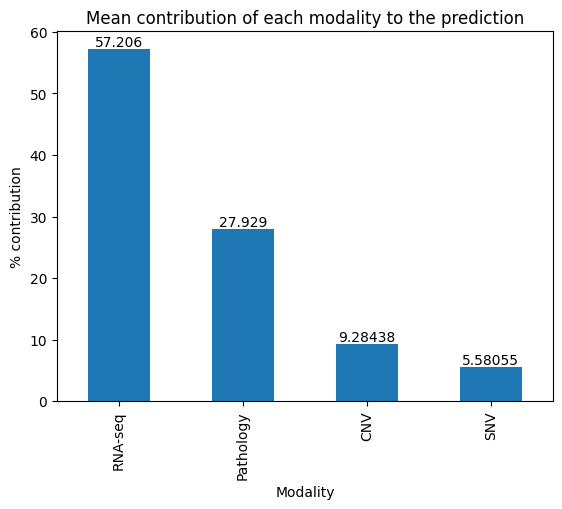

In [20]:
mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
mv_scores = pd.Series(mv_scores).sort_values(ascending=False)
mv_scores.index = pd.Series(mv_scores.index).replace({"rna": "RNA-seq", "pathology": "Pathology", "freebayes": "SNV"})
ax = mv_scores.plot(kind= "bar", ylabel= "% contribution", xlabel= "Modality", title= "Mean contribution of each modality to the prediction")
for container in ax.containers:
    ax.bar_label(container)

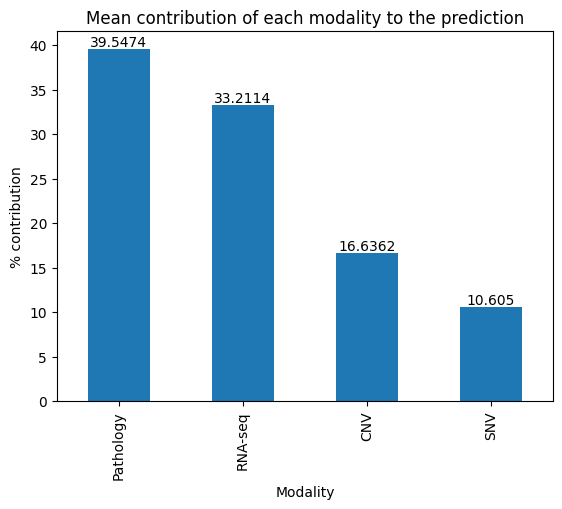

In [21]:
def compute_mv_score(shap_values, view_names, idx:int = None):
    shap_values_scores = []
    for shap_values_score in shap_values[0]:
        if idx is not None:
            shap_values_score = shap_values_score[idx]
        shap_values_scores.append(np.abs(shap_values_score).mean())
    mv_scores = {view_name : shap_values_score/sum(shap_values_scores)*100 for view_name, shap_values_score in zip(view_names, shap_values_scores)}
    return mv_scores

mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
mv_scores = pd.Series(mv_scores).sort_values(ascending=False)
mv_scores.index = pd.Series(mv_scores.index).replace({"rna": "RNA-seq", "pathology": "Pathology", "freebayes": "SNV"})
ax = mv_scores.plot(kind= "bar", ylabel= "% contribution", xlabel= "Modality", title= "Mean contribution of each modality to the prediction")
for container in ax.containers:
    ax.bar_label(container)

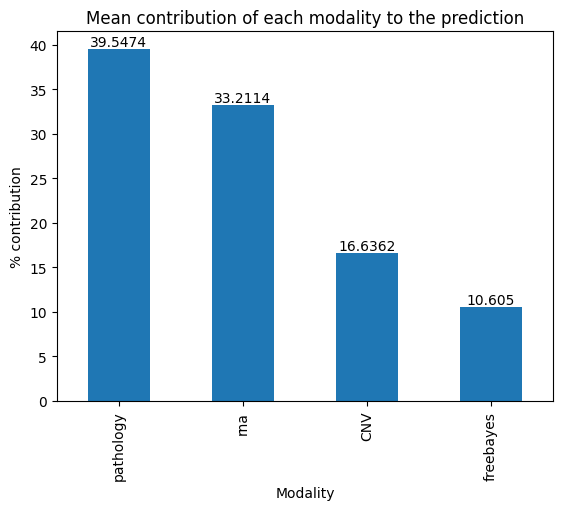

In [40]:
def compute_mv_score(shap_values, view_names, idx:int = None):
    shap_values_scores = []
    for shap_values_score in shap_values[0]:
        if idx is not None:
            shap_values_score = shap_values_score[idx]
        shap_values_scores.append(np.abs(shap_values_score).mean())
    mv_scores = {view_name : shap_values_score/sum(shap_values_scores)*100 for view_name, shap_values_score in zip(view_names, shap_values_scores)}
    return mv_scores

mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
mv_scores = pd.Series(mv_scores).sort_values(ascending=False)
ax = mv_scores.plot(kind= "bar", ylabel= "% contribution", xlabel= "Modality", title= "Mean contribution of each modality to the prediction")
for container in ax.containers:
    ax.bar_label(container)

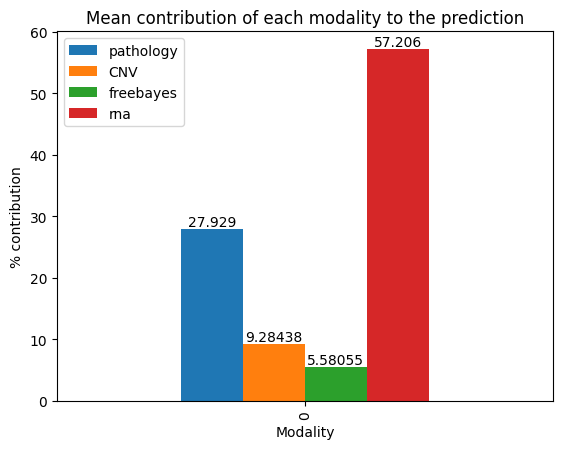

In [24]:
mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
ax = pd.DataFrame([mv_scores]).plot(kind= "bar", ylabel= "% contribution", xlabel= "Modality", title= "Mean contribution of each modality to the prediction")
for container in ax.containers:
    ax.bar_label(container)

In [336]:
mv_scores = compute_mv_score(shap_values= shap_values, view_names= views)
mv_scores = [compute_mv_score(shap_values= shap_values, view_names= views, idx = i) for i in range(len(clusters))]
mv_scores = pd.DataFrame(mv_scores, index= clusters.index)
mv_scores["clusters"] = clusters
fig, axes = plt.subplots(1, 3, figsize= (20, 4))
ax = axes[0]
mv_scores_grouped = mv_scores.replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1").groupby("clusters")
ax = mv_scores_grouped.mean().plot(kind= "bar", ylabel= "% contribution", capsize=4, yerr= mv_scores_grouped.std(), colormap= "Paired", stacked= True, ax= ax, rot= 0)
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.set_xlabel("")
ax.legend(loc= "upper center", ncols= 2, bbox_to_anchor=(0.5, 1.11))
da_for_test= [mv_scores[mv_scores['clusters'] == cl]["Methylation"] for cl in mv_scores['clusters'].unique()]
pval = round(mannwhitneyu(da_for_test[0], da_for_test[1]).pvalue, 5)
ax.text(0.35, 80, f"p= {round(pval, 3)}")

vio_met = pd.DataFrame([methylation_data[transformed_Xs[1].columns].loc[clusters == cl].mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_met, orient= "h", ax = axes[1], palette= colors)
axes[1].boxplot(vio_met, vert=False, positions= [0,1], labels= vio_met.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True)
pval = round(kstest(vio_met["Cluster 0"], vio_met["Cluster 1"]).pvalue, 5)
axes[1].text(0.8, .5, f"p= {round(pval, 3)}")

vio_rna = pd.DataFrame([rnaseq_data[transformed_Xs[0].columns].loc[clusters == cl].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_rna, orient= "h", ax = axes[2], inner=None, palette= colors)
axes[2].boxplot(vio_rna, vert=False, positions= [0,1], labels= vio_rna.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True,
                flierprops={'markersize': 1, 'markerfacecolor': 'r'})
pval = round(kstest(vio_rna["Cluster 0"], vio_rna["Cluster 1"]).pvalue, 5)
axes[2].text(14, .5, f"p= {round(pval, 3)}")

fig.subplots_adjust()
_ = fig.suptitle(None)

In [193]:
fig, axes = plt.subplots(1, 3, figsize= (20, 4))
ax = axes[0]
mv_scores_grouped = mv_scores.replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1").groupby("clusters")
ax = mv_scores_grouped.mean().plot(kind= "bar", ylabel= "% contribution", capsize=4, yerr= mv_scores_grouped.std(), colormap= "Paired", stacked= True, ax= ax, rot= 0)
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.get_children()[7].remove()
ax.set_xlabel("")
ax.legend(loc= "upper center", ncols= 2, bbox_to_anchor=(0.5, 1.11))
da_for_test= [mv_scores[mv_scores['clusters'] == cl]["Methylation"] for cl in mv_scores['clusters'].unique()]
pval = round(mannwhitneyu(da_for_test[0], da_for_test[1]).pvalue, 5)
ax.text(0.35, 80, f"p= {round(pval, 3)}")

vio_met = pd.DataFrame([methylation_data[transformed_Xs[1].columns].iloc[clusters == cl].mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_met, orient= "h", ax = axes[1], palette= colors)
axes[1].boxplot(vio_met, vert=False, positions= [0,1], labels= vio_met.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True)
pval = round(kstest(vio_met["Cluster 0"], vio_met["Cluster 1"]).pvalue, 5)
axes[1].text(0.8, .5, f"p= {round(pval, 3)}")

vio_rna = pd.DataFrame([rnaseq_data[transformed_Xs[0].columns].iloc[clusters == cl].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_rna, orient= "h", ax = axes[2], inner=None, palette= colors)
axes[2].boxplot(vio_rna, vert=False, positions= [0,1], labels= vio_rna.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True,
                flierprops={'markersize': 1, 'markerfacecolor': 'r'})
pval = round(kstest(vio_rna["Cluster 0"], vio_rna["Cluster 1"]).pvalue, 5)
axes[2].text(14, .5, f"p= {round(pval, 3)}")

fig.subplots_adjust()
_ = fig.suptitle(None)

In [329]:
mv_scores = [compute_mv_score(shap_values= shap_values, view_names= views, idx = i) for i in range(len(clusters))]
mv_scores = pd.DataFrame(mv_scores, clusters.index)
mv_scores["clusters"] = clusters
ax = mv_scores.sort_values(by= "RNAseq", ascending= True).drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", 
                                                                                         figsize= (30,8), xlabel= "Sample", colormap= "Paired", xticks= [], stacked= True)
ax.xaxis.label.set_fontsize(16)
ax.set_xlabel(ax.get_xlabel(), labelpad=20)
ax.yaxis.label.set_fontsize(16)
ax.yaxis.set_tick_params(labelsize= 16)
_ = ax.legend(loc= "upper center", prop= {"size": 16}, ncols= 2, bbox_to_anchor=(0.5, 1.09))

In [197]:
ax = mv_scores.sort_values(by= "RNAseq", ascending= True).drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", 
                                                                                         figsize= (30,8), xlabel= "Sample", colormap= "Paired", xticks= [], stacked= True)
ax.xaxis.label.set_fontsize(16)
ax.set_xlabel(ax.get_xlabel(), labelpad=20)
ax.yaxis.label.set_fontsize(16)
ax.yaxis.set_tick_params(labelsize= 16)
_ = ax.legend(loc= "upper center", prop= {"size": 16}, ncols= 2, bbox_to_anchor=(0.5, 1.09))

In [903]:
ax = mv_scores.drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", figsize= (30,8), xlabel= "Sample", colormap= "Paired", xticks= [], stacked= True)
ax.xaxis.label.set_fontsize(16)
ax.set_xlabel(ax.get_xlabel(), labelpad=20)
ax.yaxis.label.set_fontsize(16)
ax.yaxis.set_tick_params(labelsize= 16)
_ = ax.legend(loc= "upper right", prop= {"size": 16})

In [835]:
fig, axes = plt.subplots(1, 5, figsize= (20, 5), gridspec_kw={'width_ratios': [0.8, 0.1, 1, 0.01, 1]})
axes[1].set_visible(False)
axes[3].set_visible(False)
ax = axes[0]
props = mv_scores.replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1").boxplot(column= "Methylation", 
                                                                                                      by= 'clusters', figsize= (10, 4),
                                                                                                      grid= False, ylabel= "% contribution of methylation",
                                                                                                      showmeans= True, ax= ax, patch_artist=True, return_type='dict')
ax.set_xlabel("")
ax.set_title("")
ax.axhline(mv_scores["Methylation"].mean(), c= "red", linestyle= ":")
colors = ['#1f77b4', '#ff7f0e']
for i,box in enumerate(props[0]['boxes']):
    box.set_facecolor(colors[i])
ax2 = ax.twinx()
pval = round(kruskal(*[mv_scores[mv_scores['clusters'] == cl]["Methylation"] for cl in mv_scores['clusters'].unique()]).pvalue, 5)
ax.set_ylim(0,100)
ax2.set_ylim(100,0)
ax2.set_ylabel("% contribution of gene expression")
_ = ax.text(1.3, 50, f"p= {round(pval, 3)}")

vio_met = pd.DataFrame([methylation_data[transformed_Xs[1].columns].iloc[clusters == cl].mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_met, orient= "h", ax = axes[2], palette= colors)
axes[2].boxplot(vio_met, vert=False, positions= [0,1], labels= vio_met.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True)

vio_rna = pd.DataFrame([rnaseq_data[transformed_Xs[0].columns].iloc[clusters == cl].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(np.unique(clusters))],
                       index = [f"Cluster {cl}" for cl in sorted(np.unique(clusters))]).T
sns.violinplot(data= vio_rna, orient= "h", ax = axes[4], inner=None, palette= colors)
axes[4].boxplot(vio_rna, vert=False, positions= [0,1], labels= vio_rna.columns, patch_artist=True, boxprops=dict(facecolor="green"), showmeans= True,
                flierprops={'markersize': 1, 'markerfacecolor': 'r'})

fig.subplots_adjust()
_ = fig.suptitle(None)

In [553]:
mv_scores = [compute_mv_score(shap_values= shap_values, view_names= views, idx = i) for i in range(len(clusters))]
mv_scores = pd.DataFrame(mv_scores)
mv_scores["clusters"] = clusters
ax = mv_scores.drop(columns= "clusters").plot(kind= "bar", ylabel= "% contribution", figsize= (30,8), xlabel= "Samples", 
                                              title= "Contribution of each modality to the prediction")
axes = mv_scores.boxplot(by= 'clusters', figsize= (10, 4), grid= False, ylabel= "% contribution", showmeans= True)
for ax,view in zip(axes, views):
    pval = round(kruskal(*[mv_scores[mv_scores['clusters'] == cl][view] for cl in mv_scores['clusters'].unique()]).pvalue, 5)
    _ = ax.text(1.3, 50, f"p-value= {round(pval, 3)}")

In [26]:
ig = IntegratedGradients(model)
ig.gradient_func = compute_gradients
ig_nt = NoiseTunnel(ig)
gs = GradientShap(model)
gs.gradient_func = compute_gradients
fa = FeatureAblationV2(model)

ig_attr_test = ig.attribute(inputs, target = target)
ig_nt_attr_test = ig_nt.attribute(inputs, target = target)
gs_attr_test = gs.attribute(inputs, inputs, target = target)
fa_attr_test = fa.attribute(inputs, target = target)

/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: PReLU
  warnings.warn(f'unrecognized nn.Module: {module_type}')
/home/alberto/anaconda3/envs/edc_mo_pdac_val/lib/python3.11/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f'unrecognized nn.Module: {module_type}')


In [27]:
df, most_important_features = compute_most_important_features_based_attribution(features=features, algorithms=[ig_attr_test, gs_attr_test, fa_attr_test],
                                                                                names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'], top_n = 25)
weights = torch.cat([eval(f"model.autoencoder.encoder_{0}")[1][0].weight for enc in range(len(views))], dim= 1).mean(0).detach().numpy()
df["Weights"] = weights / np.linalg.norm(weights, ord=1)
df = df.loc[most_important_features]
_ = df.plot(kind= "bar", figsize = (20, 8), ylabel= "Attribution", colormap= "tab10")

NameError: name 'features' is not defined

In [543]:
plot_attribution_algorithm_comparison(features=features, algorithms= [ig_attr_test, gs_attr_test, fa_attr_test],
                                      names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'],
                                      weights= [eval(f"model.autoencoder.encoder_{0}")[1][0].weight for enc in range(len(views))],
                                      top_n = 10, figsize = (20, 8))

In [837]:
df = pd.concat(Xs, axis= 1)
_, most_important_features = compute_most_important_features_based_attribution(features=features, algorithms= [ig_attr_test, gs_attr_test, fa_attr_test],
                                                                               names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'], top_n = 25)
most_important_features = [i.split("_")[-1] for i in most_important_features]
df = df[most_important_features]
df["clusters"] = clusters
df = df.fillna(df.mean())

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters').replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1"),
                 x="variable", y="value", hue="clusters", hue_order= ["Cluster 0", "Cluster 1"], showmeans= True, palette= colors)
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "", loc= "lower right")
ax.set_xlabel("")
ax.set_ylabel("Beta value")
ax.set_title("")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, .98, f"p={pvals[xtick]}", size='x-small', color= c.iloc[xtick])

In [546]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

In [547]:
df = pd.concat(transformed_Xs, axis= 1)
_, most_important_features = compute_most_important_features_based_attribution(features=features, algorithms= [ig_attr_test, gs_attr_test, fa_attr_test],
                                                                               names= ['Int Grads', 'GradientSHAP', 'Feature Ablation'], top_n = 25)
most_important_features = [i.split("_")[-1] for i in most_important_features]
df = df[most_important_features]
df["clusters"] = clusters

fig, axes = plt.subplots(2, 1, figsize= (8, 10))

ax = axes[0]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h", ax = ax)
ax.set_title("All feature values by cluster")

ax = axes[1]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h",  ax = ax)
_ = ax.set_title("Mean feature values by cluster")

In [231]:
pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T

In [260]:
df

In [266]:
most_important_features = ["cg10794257", "cg03306374", "cg09656848", "cg27633530", "cg16729415", "cg03650946", "cg16856286", "cg04344565", "cg11527326",
                           "cg22674699", "cg27058257", "cg20718350", "cg16427096", "cg07589773", "cg01277542", "cg07085827", "cg12559197", "cg14004073",
                           "cg16816603", "cg09053680", "cg12040830", "cg09493505", "cg20482698", "cg21097881", "cg21039708"]

df = pd.concat(Xs, axis= 1)[most_important_features]
df["clusters"] = pd.Series(clusters).replace(0, "Cluster 0").replace(1, "Cluster 1").values
ax = sns.violinplot(data= df.groupby("clusters").mean().T, orient= "h")

In [294]:
ax.figure

In [314]:
df = pd.concat(Xs, axis= 1)
df = df[most_important_features]
df["clusters"] = clusters
df = df.fillna(df.mean())

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters').replace({"clusters", 0}, "Cluster 0").replace({"clusters", 1}, "Cluster 1"),
                 x="variable", y="value", hue="clusters", hue_order= ["Cluster 0", "Cluster 1"], showmeans= True, palette= colors)
ax.tick_params(axis='x', rotation=90)
ax.legend(loc= "upper center", ncols= 2, bbox_to_anchor=(0.5, 1.06))

# ax.legend(title= "", loc= "lower right")
ax.set_xlabel("")
ax.set_ylabel("Beta value")
ax.set_title("")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, .98, f"p={pvals[xtick]}", size='x-small', color= c.iloc[xtick])

In [403]:
from scipy.stats import pearsonr
plt.figure(figsize=(20,13))
corr = df.drop(columns= "clusters").corr(lambda x,y: pearsonr(x,y)[1])
corr = corr.replace(1, 0) * (corr.size/2 - len(corr))
ax = sns.heatmap(corr,annot=True, cmap= "coolwarm", fmt= ".3f", vmax=1)

In [302]:
plt.figure(figsize=(20,13))
corr = df.drop(columns= "clusters").corr().replace(1, np.nan)
ax = sns.heatmap(corr,annot=True, cmap= "coolwarm", fmt= ".2f", vmin= -1, vmax= 1)
# ax.figure.colorbar(ax.collections[0]).set_clim(-1,1)

In [ ]:
ax = axes[1]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h",  ax = ax)
_ = ax.set_title("Mean feature values by cluster")

In [548]:
fig, axes = plt.subplots(2, 1, figsize= (8, 10))

ax = axes[0]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h", ax = ax)
ax.set_title("All feature values by cluster")

ax = axes[1]
ax = sns.violinplot(data= pd.DataFrame([df.loc[df["clusters"] == cl].drop(columns= "clusters").mean(0).values.flatten() for cl in sorted(df["clusters"].unique())],
                                      index = [cl for cl in sorted(df["clusters"].unique())]).T, orient= "h",  ax = ax)
_ = ax.set_title("Mean feature values by cluster")

In [ ]:
layer = eval(f"model.autoencoder.encoder_{model.autoencoder.views}")
lc = LayerConductance(model, layer[1], device_ids = model.cluster_centers_.device)
lc._attribute = types.MethodType(layerconductance._attribute, lc)

In [851]:
def plot_comparison_attributions_weights_(lc_attr, weights, layer_name = "embedding", figsize=(15, 8)):
    plt.figure(figsize=figsize)
    x_axis_data = np.arange(lc_attr.shape[1])
    y_axis_lc_attr = lc_attr.mean(0)
    y_axis_lc_attr = y_axis_lc_attr / np.linalg.norm(y_axis_lc_attr, ord=1)
    
    y_axis_layer_weight = weights.mean(1)
    y_axis_layer_weight = y_axis_layer_weight / np.linalg.norm(y_axis_layer_weight, ord=1)
    width = 0.25
    legends = ['Attributions','Weights']
    ax = plt.subplot()
    ax.bar(x_axis_data + width, y_axis_lc_attr, width, align='center', alpha=0.5, color='red')
    ax.bar(x_axis_data + 2 * width, y_axis_layer_weight, width, align='center', alpha=0.5, color='green')
    ax.set_ylabel("Attribution")
    ax.set_xlabel("Neuron")
    plt.legend(legends)
    ax.autoscale_view()
    if len(y_axis_layer_weight) <= 100:
        x_axis_labels = list(range(len(y_axis_layer_weight)))
        ax.set_xticks(x_axis_data + 0.5)
        ax.set_xticklabels(x_axis_labels)
    plt.show()


plot_comparison_attributions_weights_(lc_attr = lc_attr_test.detach().numpy(), weights = layer[0].weight.detach().numpy(), layer_name = "embedding", figsize=(20, 8))

In [549]:
lc_attr_test = lc.attribute(inputs = inputs, baselines=baselines, target = target)
plot_comparison_attributions_weights(lc_attr = lc_attr_test.detach().numpy(), weights = layer[0].weight.detach().numpy(), layer_name = "embedding", figsize=(20, 8))

In [550]:
cond_vals = lc_attr_test.detach().numpy()
sorted_neurons = np.abs(cond_vals.mean(0)).argsort()[::-1].tolist()
plot_attribution_distribution(cond_vals = cond_vals, figsize = (20, 8), strong_features = sorted_neurons[:3], weak_features = sorted_neurons[-3:][::-1])

In [ ]:
neuron_cond = NeuronConductance(model, layer[1], device_ids = model.cluster_centers_.device)
neuron_cond._attribute = types.MethodType(neuronconductance._attribute, neuron_cond)

In [863]:
df = pd.DataFrame()

for neuron_selector in sorted_neurons:
    neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
    importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
    most_important_features = features.to_frame("feature")
    most_important_features["importance"] = importances
    for view in views:
        df.loc[neuron_selector, view] = most_important_features[most_important_features["feature"].str.startswith(view)]["importance"].sum()

df[df < 0] = 0
df = (df.T / df.sum(1)).T
df = df.dropna()
df = df.round(2) * 100
df = df.astype(int)

ax = df.plot(kind='bar', stacked=True, figsize= (25, 5), xlabel= "Neuron", ylabel= "% contribution", colormap= "Paired")
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

In [530]:
neuron_selector = sorted_neurons[0]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 25, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

In [531]:
importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
most_important_features = features.to_frame("feature")
most_important_features["importance"] = importances
most_important_features = most_important_features.sort_values("importance", ascending= False).iloc[:25]
most_important_features = most_important_features.set_index("feature")
df = pd.concat(transformed_Xs, axis= 1)
most_important_features = [i.split("_")[-1] for i in most_important_features.index.to_list()]
df = df[most_important_features]
df["clusters"] = clusters

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters'), x="variable", y="value", hue="clusters", showmeans= True)
ax.set_title(f"Boxplots for top input features for neuron {neuron_selector} grouped by clusters")
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "clusters", loc= "lower right")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, 3.3, pvals[xtick], size='x-small', color= c.iloc[xtick])

In [532]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

In [533]:
neuron_selector = sorted_neurons[1]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 25, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

In [534]:
importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
most_important_features = features.to_frame("feature")
most_important_features["importance"] = importances
most_important_features = most_important_features.sort_values("importance", ascending= False).iloc[:25]
most_important_features = most_important_features.set_index("feature")
df = pd.concat(transformed_Xs, axis= 1)
most_important_features = [i.split("_")[-1] for i in most_important_features.index.to_list()]
df = df[most_important_features]
df["clusters"] = clusters

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters'), x="variable", y="value", hue="clusters", showmeans= True)
ax.set_title(f"Boxplots for top input features for neuron {neuron_selector} grouped by clusters")
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "clusters", loc= "lower right")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, 5.3, pvals[xtick], size='x-small', color= c.iloc[xtick])

In [535]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))

In [536]:
neuron_selector = sorted_neurons[2]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 25, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

In [537]:
importances = torch.cat(neuron_cond_vals, 1).mean(0).detach().numpy()
most_important_features = features.to_frame("feature")
most_important_features["importance"] = importances
most_important_features = most_important_features.sort_values("importance", ascending= False).iloc[:25]
most_important_features = most_important_features.set_index("feature")
df = pd.concat(transformed_Xs, axis= 1)
most_important_features = [i.split("_")[-1] for i in most_important_features.index.to_list()]
df = df[most_important_features]
df["clusters"] = clusters

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=pd.melt(df, id_vars='clusters'), x="variable", y="value", hue="clusters", showmeans= True)
ax.set_title(f"Boxplots for top input features for neuron {neuron_selector} grouped by clusters")
ax.tick_params(axis='x', rotation=90)
ax.legend(title= "clusters", loc= "lower right")

pvals = [kruskal(*[df[df['clusters'] == cl][feature] for cl in df['clusters'].unique()]).pvalue for feature in most_important_features]
c, pvals = fdrcorrection(pvals)
c, pvals = pd.Series(c).apply(lambda x: "red" if x else "black"), pvals.round(3)

for xtick in ax.get_xticks():
    ax.text(xtick-0.2, 5.3, pvals[xtick], size='x-small', color= c.iloc[xtick])

In [538]:
print("Accuracy score =", cross_val_score(SVC(), df[most_important_features], df["clusters"], cv= 5).mean().round(2))